# Random Forest Regression - Real Estate Price Prediction

This notebook builds a Random Forest regression model to predict property prices (price_per_m2) using the processed alonhadat dataset. Random Forest is an ensemble learning method that combines multiple decision trees to improve prediction accuracy and control overfitting.

## 1. Import Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data

In [27]:
# Load the preprocessed data
df = pd.read_csv('../../Data Preprocessing/alonhadat_processed.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (14415, 16)

First few rows:


,address,area,bedrooms,date,floors,price,title,road,ward,district,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2
0,"Đường Nguyễn Văn Cừ, Phường Gia Thụy, Quận Lon...",80,1,Hôm nay,1,"7,5 tỷ","🥇ĐẤT NGUYỄN VĂN CỪ 80M, MT8M, MẢNH ĐẤT RỘNG TH...",Nguyễn Văn Cừ,Gia Thụy,Long Biên,1,564,54,11,7500.00,93.75
1,"Đường Ngọc Lâm, Phường Ngọc Lâm, Quận Long Biê...",36,3,Hôm nay,6,"8,65 tỷ","🔥CÒN DUY NHẤT 1 CĂN GIÁ RẺ, NGỌC LÂM 36M, 6T G...",Ngọc Lâm,Ngọc Lâm,Long Biên,1,603,157,11,8650.00,240.28
2,"Đường Ngô Gia Tự, Phường Đức Giang, Quận Long ...",56,1,Hôm nay,1,"15,5 tỷ","👉MẶT PHỐ, NGÔ GIA TỰ, 56M, MT4M, VỈA HÈ ĐÁ BÓN...",Ngô Gia Tự,Đức Giang,Long Biên,1,587,390,11,15500.00,276.79
3,"Đường Phúc Lợi, Phường Phúc Lợi, Quận Long Biê...",32,3,Hôm nay,5,"5,2 tỷ","🥇CĂN DUY NHẤT, NGÕ THÔNG, Ô TÔ , LÔ GÓC, PHÚC ...",Phúc Lợi,Phúc Lợi,Long Biên,1,667,193,11,5200.00,162.50
4,"Phố Lệ Mật, Phường Việt Hưng, Quận Long Biên, ...",58,3,Hôm nay,3,7 tỷ,"🏡VIỆT HƯNG, DIỆN TÍCH RỘNG 58m, 3T, MT5m GIÁ C...",Lệ Mật,Việt Hưng,Long Biên,1,445,313,11,7000.00,120.69


## 3. Feature Selection and Data Preparation

We'll use the same features as in the previous models for consistency and comparability.

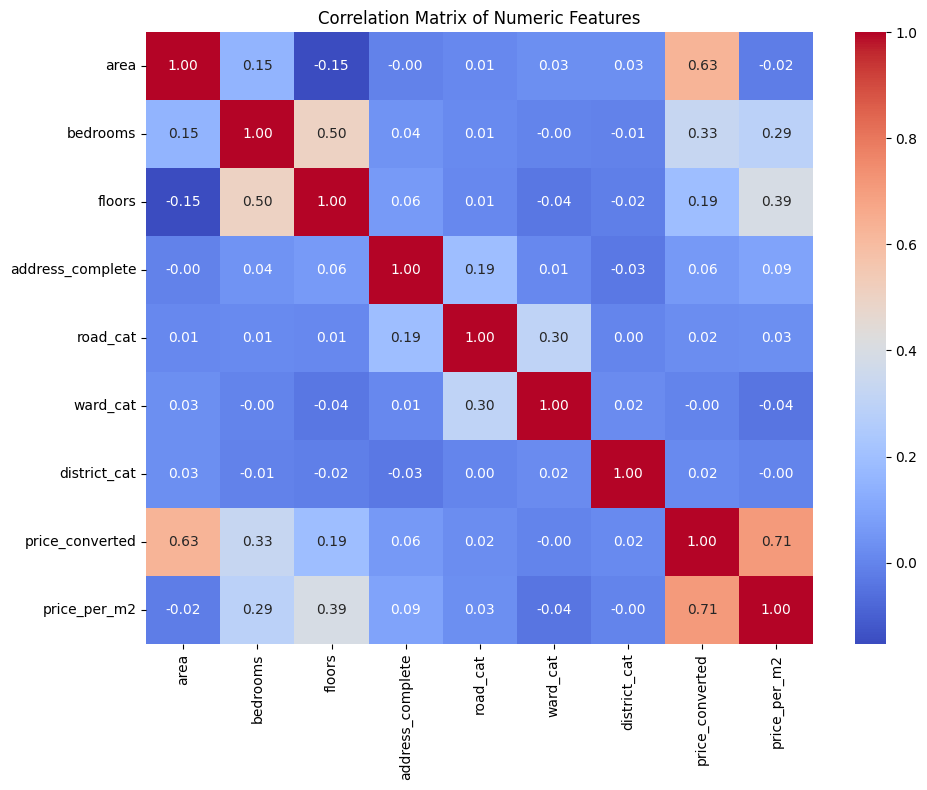

Correlations with price_per_m2:
price_per_m2        1.00
price_converted     0.71
floors              0.39
bedrooms            0.29
address_complete    0.09
road_cat            0.03
district_cat       -0.00
area               -0.02
ward_cat           -0.04
Name: price_per_m2, dtype: float64


In [28]:
# Examine correlations with price_per_m2 to inform feature selection
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Print correlations with price_per_m2
price_correlations = correlation_matrix['price_per_m2'].sort_values(ascending=False)
print("Correlations with price_per_m2:")
print(price_correlations)

In [29]:
# Select features for modeling
# Numeric features (excluding price and price_per_m2 which are target related)
numeric_features = ['area', 'bedrooms', 'floors', 'address_complete']

# Categorical features that might affect price
categorical_features = ['district']  # We could add more like 'ward' if needed

# Define features and target
X = df[numeric_features + categorical_features].copy()
y = df['price_per_m2']

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature set sample:")
X.head()

Feature set shape: (14415, 5)
Target shape: (14415,)

Feature set sample:


,area,bedrooms,floors,address_complete,district
0,80,1,1,1,Long Biên
1,36,3,6,1,Long Biên
2,56,1,1,1,Long Biên
3,32,3,5,1,Long Biên
4,58,3,3,1,Long Biên


## 4. Data Preprocessing Pipeline

We'll create a preprocessing pipeline similar to the one used for the previous models:
1. Standard scaling for numeric features
2. One-hot encoding for categorical features

In [30]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Display the preprocessing pipeline
print("Preprocessing Pipeline:")
print(preprocessor)

Preprocessing Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['area', 'bedrooms', 'floors',
                                  'address_complete']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['district'])])


## 5. Split Data and Train Random Forest Model

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (11532, 5)
Testing set shape: (2883, 5)


## 6. Hyperparameter Tuning with GridSearchCV

We'll tune the following hyperparameters for the Random Forest regressor:
1. n_estimators: The number of trees in the forest
2. max_depth: The maximum depth of the trees
3. min_samples_split: The minimum number of samples required to split an internal node
4. min_samples_leaf: The minimum number of samples required to be at a leaf node

In [ ]:
# Create the Random Forest pipeline with preprocessing
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],  # Expanded n_estimators
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', 0.7]  # Added max_features
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to find optimal parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # Convert back to RMSE

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation RMSE: {best_score:.2f} million VND/m²")

# Create the best Random Forest model
best_rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=best_params['regressor__n_estimators'],
        max_depth=best_params['regressor__max_depth'],
        min_samples_split=best_params['regressor__min_samples_split'],
        min_samples_leaf=best_params['regressor__min_samples_leaf'],
        max_features=best_params['regressor__max_features'], # Ensure this is used
        random_state=42
    ))
])

# Train the best model
best_rf_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


## 7. Model Evaluation

In [ ]:
# Make predictions
y_train_pred = best_rf_pipeline.predict(X_train)
y_test_pred = best_rf_pipeline.predict(X_test)

# Evaluate the model
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Random Forest Regression Model Performance:")
print(f"Training R² Score: {train_r2:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f} million VND/m²")
print(f"Testing RMSE: {test_rmse:.2f} million VND/m²")
print(f"Training MAE: {train_mae:.2f} million VND/m²")
print(f"Testing MAE: {test_mae:.2f} million VND/m²")

Random Forest Regression Model Performance:
Training R² Score: 0.5360
Testing R² Score: 0.3727
Training RMSE: 63.64 million VND/m²
Testing RMSE: 72.95 million VND/m²
Training MAE: 48.42 million VND/m²
Testing MAE: 54.90 million VND/m²


## 8. Visualize Results

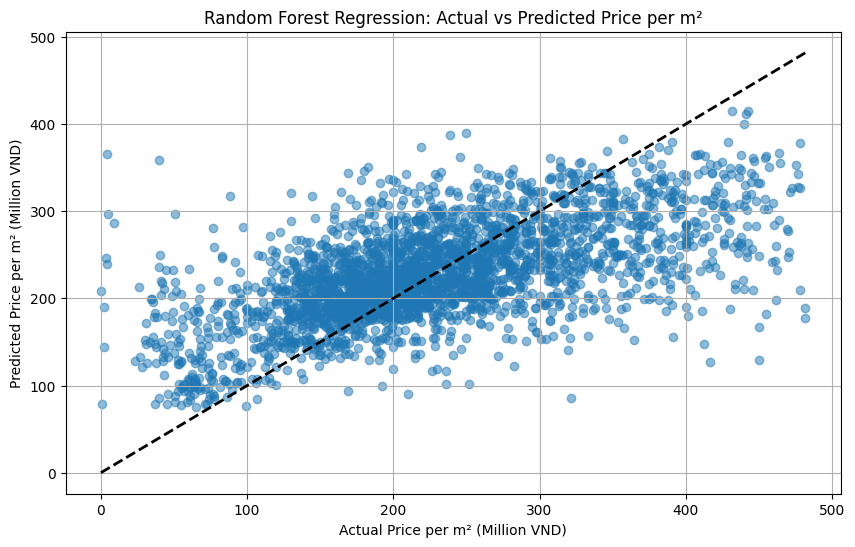

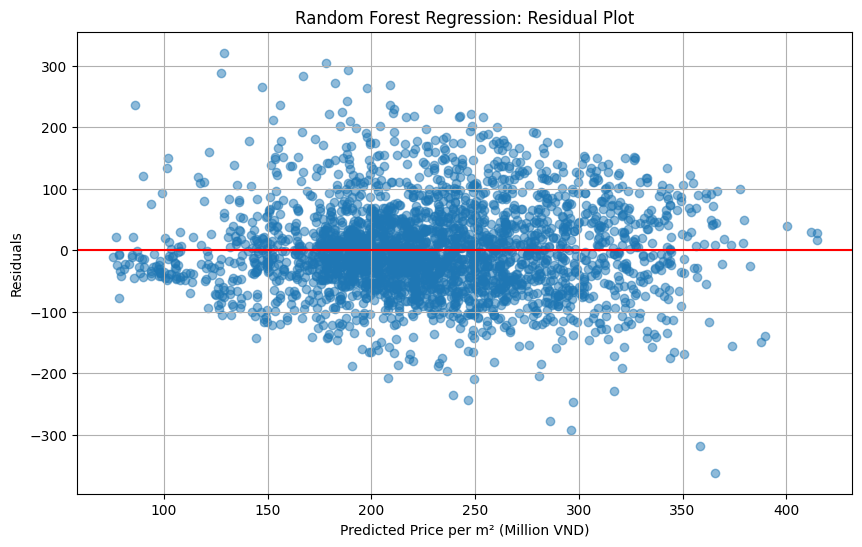

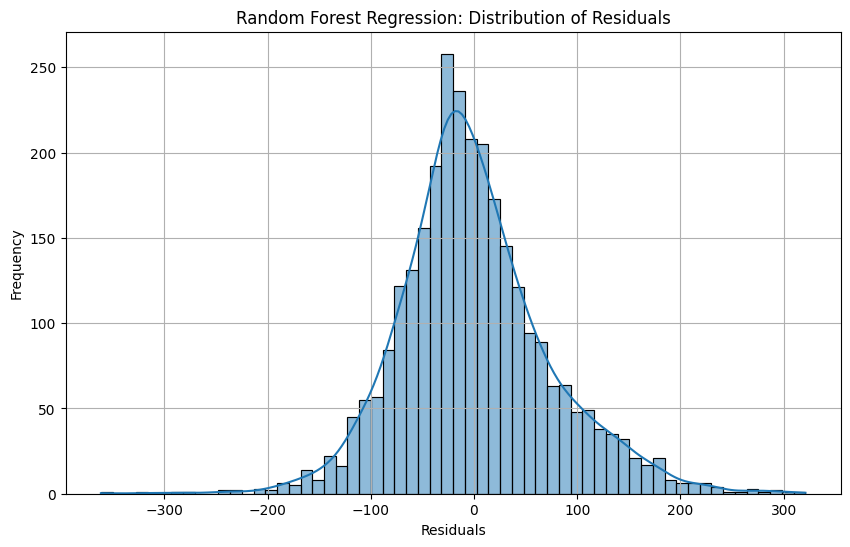

In [ ]:
# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price per m² (Million VND)')
plt.ylabel('Predicted Price per m² (Million VND)')
plt.title('Random Forest Regression: Actual vs Predicted Price per m²')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Price per m² (Million VND)')
plt.ylabel('Residuals')
plt.title('Random Forest Regression: Residual Plot')
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Random Forest Regression: Distribution of Residuals')
plt.grid(True)
plt.show()

## 9. Feature Importance Analysis

One of the advantages of Random Forest is that it provides a measure of feature importance. Let's look at which features have the most impact on our predictions.

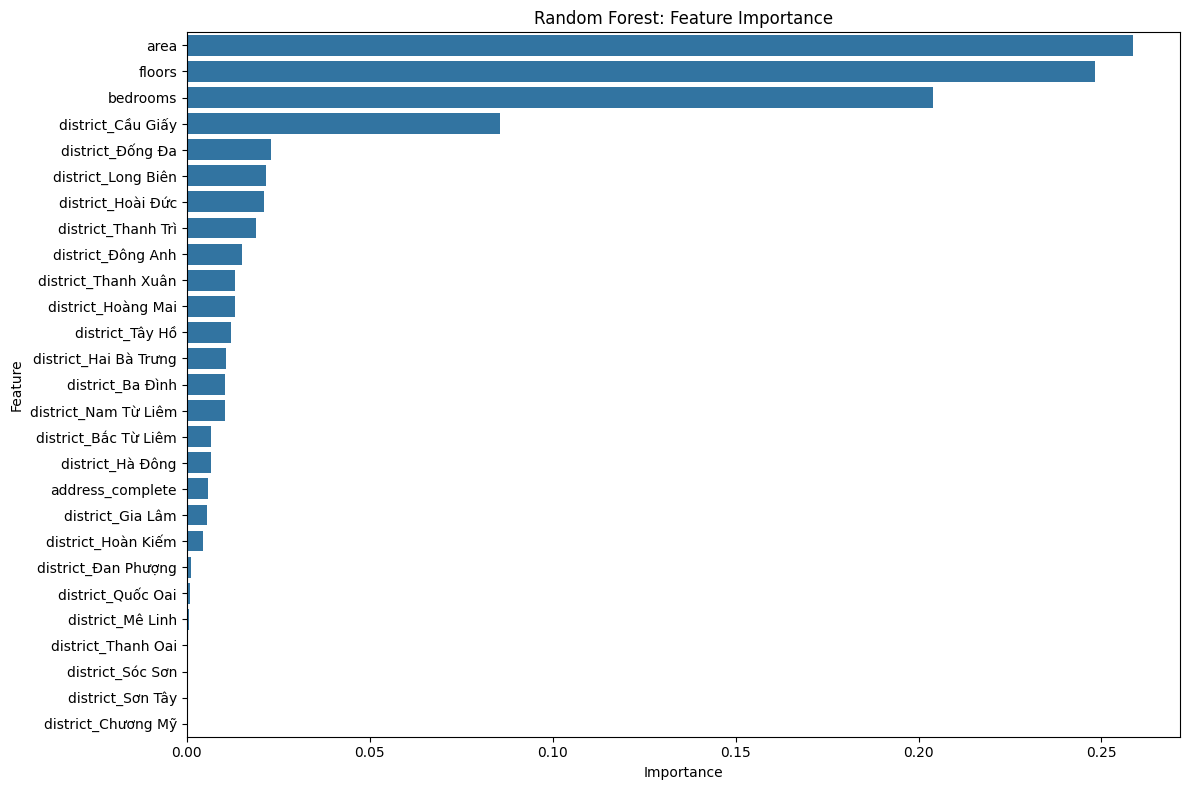

Top 10 Most Important Features:
area                  0.26
floors                0.25
bedrooms              0.20
district_Cầu Giấy     0.09
district_Đống Đa      0.02
district_Long Biên    0.02
district_Hoài Đức     0.02
district_Thanh Trì    0.02
district_Đông Anh     0.02
district_Thanh Xuân   0.01
dtype: float64


In [ ]:
# Get feature names from the preprocessor
ohe_feature_names = best_rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(ohe_feature_names)

# Get feature importances
importances = best_rf_pipeline.named_steps['regressor'].feature_importances_

# Create a pandas Series for better visualization
feature_importance = pd.Series(importances, index=feature_names)
feature_importance = feature_importance.sort_values(ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Random Forest: Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance.head(10))

## 10. Examine Predictions by District

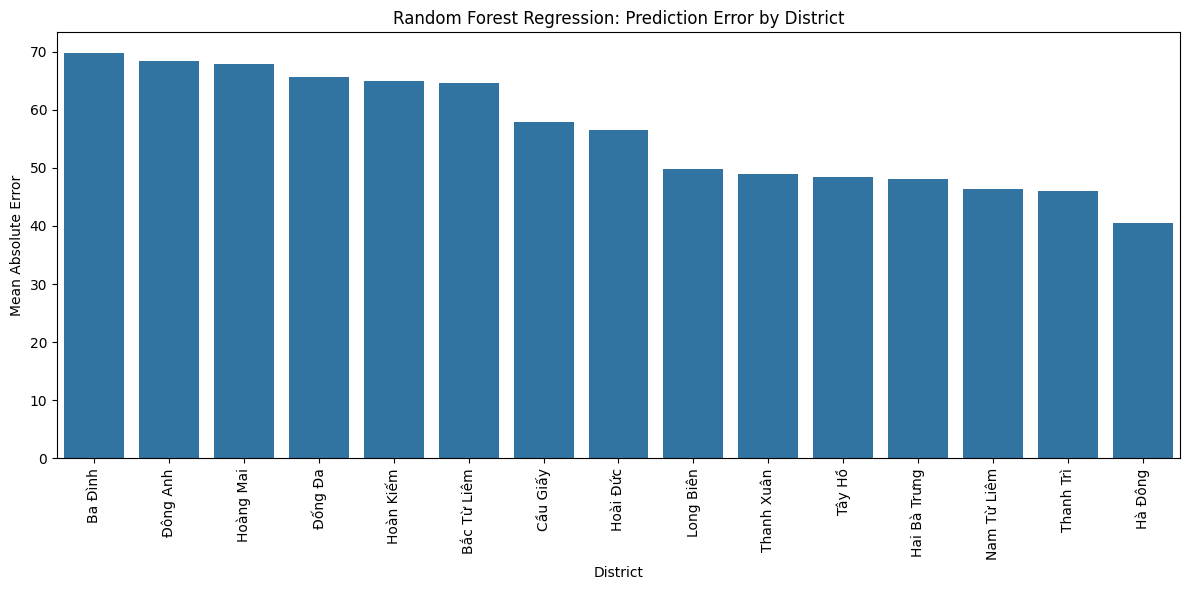

In [ ]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Residual': residuals
})

# Add district information from test set
results_df['district'] = X_test.reset_index()['district']

# Calculate mean absolute error by district
district_mae = results_df.groupby('district')['Residual'].apply(lambda x: np.mean(np.abs(x)))
district_mae = district_mae.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=district_mae.index, y=district_mae.values)
plt.xticks(rotation=90)
plt.xlabel('District')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest Regression: Prediction Error by District')
plt.tight_layout()
plt.show()